# Compose Complete DataFrame


# Predicting NFL Win Totals

## BASELINE

## constraints
- years: 2009-present
- all 32 teams


## Model
- Random Forest

## Dependent Variable
- Current Year's Win Total

## Independent Variables
- [x]  Previous Year's Strength of Schedule
- [x] Current Year's Market-Priced Strength of Schedule
- [ ] Previous Year's Relative Performance (EPA Standardized w.r.t Year)

In [1]:
# import python packages & libraries
import numpy as np
import pandas as pd
import nfl_data_py as nfl

In [2]:
YEARS = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
CURRENT_YEAR = 2022

# Get Data
- Previous Year's Strength of Schedule
    - Each opposing team's previous year's Win PCT
        - Obtain schedule for the `result` for `game_type` REG season (ref: data_dict https://github.com/nflverse/nflreadr/blob/main/data-raw/dictionary_schedules.csv)
        - Transform schedule result to win/loss
        - Group Year & Team to obtain sum of wins / count games played
- Current Year's Market-Priced Strength of Schedule
    - Each opposing team's expected Win PCT
- Previous Year's Relative Performance
    - Team's EPA standardized w.r.t Year's mean team EPA
    

## Previous Year's Strength of Schedule

In [3]:
# import the NFL schedule
nfl_schedule = nfl.import_schedules(years=YEARS)

In [4]:
nfl_wins = nfl_schedule.loc[nfl_schedule['game_type'] == 'REG',['game_id','season','game_type','home_team','away_team','result']]

In [5]:
nfl_wins = pd.melt(nfl_wins, id_vars=['game_id','season','game_type','result'], var_name=['home_away'], value_vars=['home_team', 'away_team'], value_name='team_name')

In [6]:
home_team_score_more = (nfl_wins.result > 0) & (nfl_wins.home_away == 'home_team')
away_team_score_more = (nfl_wins.result < 0) & (nfl_wins.home_away == 'away_team')
team_score_tie = (nfl_wins.result == 0)
home_win = 1
away_win = 1
tie = 0
conditions = [home_team_score_more, away_team_score_more, team_score_tie]
results = [home_win, away_win, tie]
nfl_wins['win'] = np.select(conditions, results, default=0)

In [7]:
home_team_score_less = (nfl_wins.result < 0) & (nfl_wins.home_away == 'home_team')
away_team_score_less = (nfl_wins.result > 0) & (nfl_wins.home_away == 'away_team')
team_score_tie = (nfl_wins.result == 0)
home_loss = 1
away_loss = 1
tie = 0
conditions = [home_team_score_less, away_team_score_less, team_score_tie]
results = [home_loss, away_loss, tie]
nfl_wins['loss'] = np.select(conditions, results, default=0)

In [8]:
home_team_score_less = (nfl_wins.result < 0) & (nfl_wins.home_away == 'home_team')
away_team_score_less = (nfl_wins.result > 0) & (nfl_wins.home_away == 'away_team')
team_score_tie = (nfl_wins.result == 0)
home_loss = 0
away_loss = 0
tie = 1
conditions = [home_team_score_less, away_team_score_less, team_score_tie]
results = [home_loss, away_loss, tie]
nfl_wins['tie'] = np.select(conditions, results, default=0)

In [9]:
nfl_records = nfl_wins.groupby(['team_name','season']).agg({'win':'sum', 'loss':'sum', 'tie':'sum'}).reset_index()
nfl_records

,team_name,season,win,loss,tie
0,ARI,2009,10,6,0
1,ARI,2010,5,11,0
2,ARI,2011,8,8,0
3,ARI,2012,5,11,0
4,ARI,2013,10,6,0
...,...,...,...,...,...
443,WAS,2018,7,9,0
444,WAS,2019,3,13,0
445,WAS,2020,7,9,0
446,WAS,2021,7,10,0


In [10]:
wins2 = nfl_wins.copy()

In [11]:
temp = wins2.groupby('game_id')['team_name'].agg(pd.Series.tolist).reset_index().rename(columns={'team_name':'game_teams'})
temp

,game_id,game_teams
0,2009_01_BUF_NE,"[NE, BUF]"
1,2009_01_CHI_GB,"[GB, CHI]"
2,2009_01_DAL_TB,"[TB, DAL]"
3,2009_01_DEN_CIN,"[CIN, DEN]"
4,2009_01_DET_NO,"[NO, DET]"
...,...,...
3611,2022_18_NE_BUF,"[BUF, NE]"
3612,2022_18_NYG_PHI,"[PHI, NYG]"
3613,2022_18_NYJ_MIA,"[MIA, NYJ]"
3614,2022_18_TB_ATL,"[ATL, TB]"


In [12]:
wins2 = pd.merge(wins2, temp, on='game_id')

In [13]:
match_team_name = (wins2.team_name == wins2.game_teams.str[0])
conditions = [match_team_name]
team2 = wins2.game_teams.str[1]
results = [team2]
wins2['opposing_team'] = np.select(conditions, results, default=wins2.game_teams.str[0])

In [14]:
wins2

,game_id,season,game_type,result,home_away,team_name,win,loss,tie,game_teams,opposing_team
0,2009_01_TEN_PIT,2009,REG,3.0,home_team,PIT,1,0,0,"[PIT, TEN]",TEN
1,2009_01_TEN_PIT,2009,REG,3.0,away_team,TEN,0,1,0,"[PIT, TEN]",PIT
2,2009_01_MIA_ATL,2009,REG,12.0,home_team,ATL,1,0,0,"[ATL, MIA]",MIA
3,2009_01_MIA_ATL,2009,REG,12.0,away_team,MIA,0,1,0,"[ATL, MIA]",ATL
4,2009_01_KC_BAL,2009,REG,14.0,home_team,BAL,1,0,0,"[BAL, KC]",KC
...,...,...,...,...,...,...,...,...,...,...,...
7227,2022_18_LA_SEA,2022,REG,NaN,away_team,LA,0,0,0,"[SEA, LA]",SEA
7228,2022_18_ARI_SF,2022,REG,NaN,home_team,SF,0,0,0,"[SF, ARI]",ARI
7229,2022_18_ARI_SF,2022,REG,NaN,away_team,ARI,0,0,0,"[SF, ARI]",SF
7230,2022_18_DAL_WAS,2022,REG,NaN,home_team,WAS,0,0,0,"[WAS, DAL]",DAL


In [15]:
# nfl_records['win_pct'] = nfl_records['win_pct'].round(3)
nfl_records['season_n'] = nfl_records['season'] +1
nfl_records.rename(columns={'season':'season_n-1','team_name':'matching_opposing_team_name','win':'season_n-1_win_total','loss':'season_n-1_loss_total', 'tie':'season_n-1_tie_total'}, inplace=True)
nfl_records['season_n-1_games_played'] = nfl_records[['season_n-1_win_total','season_n-1_loss_total','season_n-1_tie_total']].sum(axis=1)
nfl_records

,matching_opposing_team_name,season_n-1,season_n-1_win_total,season_n-1_loss_total,season_n-1_tie_total,season_n,season_n-1_games_played
0,ARI,2009,10,6,0,2010,16
1,ARI,2010,5,11,0,2011,16
2,ARI,2011,8,8,0,2012,16
3,ARI,2012,5,11,0,2013,16
4,ARI,2013,10,6,0,2014,16
...,...,...,...,...,...,...,...
443,WAS,2018,7,9,0,2019,16
444,WAS,2019,3,13,0,2020,16
445,WAS,2020,7,9,0,2021,16
446,WAS,2021,7,10,0,2022,17


In [16]:
# adjust for team's relocation: OAK -> LV
team_OAK = nfl_records['matching_opposing_team_name'] == 'OAK'
season_2019 = nfl_records['season_n-1'] == 2019
nfl_records.loc[((team_OAK)&(season_2019)),'matching_opposing_team_name'] = 'LV'

# adjust for team's relocation: SD -> LAC
team_SD = nfl_records['matching_opposing_team_name'] == 'SD'
season_2016 = nfl_records['season_n-1'] == 2016
nfl_records.loc[((team_SD)&(season_2016)),'matching_opposing_team_name'] = 'LAC'

# adjust for team's relocation: STL -> LA
team_STL = nfl_records['matching_opposing_team_name'] == 'STL'
season_2015 = nfl_records['season_n-1'] == 2015
nfl_records.loc[((team_STL)&(season_2015)),'matching_opposing_team_name'] = 'LA'


In [17]:
assert all(nfl_records.loc[(nfl_records['season_n-1'] < 2021),'season_n-1_games_played'] == 16), "Not all opposing_team season_n-1_games_played are accounted"
assert all((nfl_records.loc[(nfl_records['season_n-1'] >= 2021),'season_n-1_games_played'] == 17) | (nfl_records.loc[(nfl_records['season_n-1'] >= 2021),'season_n'] == CURRENT_YEAR+1)), "Not all opposing_team season_n-1_games_played are accounted"

In [18]:
nfl_records

,matching_opposing_team_name,season_n-1,season_n-1_win_total,season_n-1_loss_total,season_n-1_tie_total,season_n,season_n-1_games_played
0,ARI,2009,10,6,0,2010,16
1,ARI,2010,5,11,0,2011,16
2,ARI,2011,8,8,0,2012,16
3,ARI,2012,5,11,0,2013,16
4,ARI,2013,10,6,0,2014,16
...,...,...,...,...,...,...,...
443,WAS,2018,7,9,0,2019,16
444,WAS,2019,3,13,0,2020,16
445,WAS,2020,7,9,0,2021,16
446,WAS,2021,7,10,0,2022,17


In [19]:
win_pct = pd.merge(wins2, nfl_records, left_on=['season','opposing_team'], right_on=['season_n','matching_opposing_team_name'])

In [20]:
# win_pct.groupby(['season_n','team_name_x']).agg({'win_total':'sum','loss_total':'sum', 'tie_total':'sum'}).sum(axis=1).sort_values()
wins3 = win_pct.groupby(['season_n','team_name']).agg({'season_n-1_win_total':'sum','season_n-1_loss_total':'sum', 'season_n-1_tie_total':'sum', 'season_n-1_games_played':'sum'}).reset_index()

In [21]:
wins3.rename(columns= {'season_n-1_win_total':'season_n-1_opposing_win_total','season_n-1_loss_total':'season_n-1_opposing_loss_total','season_n-1_tie_total':'season_n-1_opposing_tie_total'},inplace=True)
wins3['season_n-1_opposing_win_pct'] = (wins3['season_n-1_opposing_win_total'] + 0.5*wins3['season_n-1_opposing_tie_total'] ) / wins3['season_n-1_games_played']

In [27]:
wins3

,season_n,team_name,season_n-1_opposing_win_total,season_n-1_opposing_loss_total,season_n-1_opposing_tie_total,season_n-1_games_played,season_n-1_opposing_win_pct
0,2010,ARI,114,142,0,256,0.445312
1,2010,ATL,127,129,0,256,0.496094
2,2010,BAL,130,126,0,256,0.507812
3,2010,BUF,128,128,0,256,0.500000
4,2010,CAR,122,134,0,256,0.476562
...,...,...,...,...,...,...,...
411,2022,SEA,149,139,1,289,0.517301
412,2022,SF,154,135,0,289,0.532872
413,2022,TB,154,134,1,289,0.534602
414,2022,TEN,136,153,0,289,0.470588


## Current Year's Market-Priced Strength of Schedule

In [28]:
# Create for-loop to grab sportsoddshistory pages. 
#  add season YEAR to the DataFrame
#  concat the data to create a single DataFrame
#  adjust team_name

# import nfl schedule and 
# calculate opposing team's market-line of win pct

In [66]:
nfl_market_exp_wins = pd.DataFrame()

for year in YEARS:
    sportsoddshistory = pd.read_html(f'https://www.sportsoddshistory.com/nfl-win/?y={year}&sa=nfl&t=win&o=t')
    sportsoddshistory[0]['season_n'] = year
    nfl_market_exp_wins = pd.concat([nfl_market_exp_wins,sportsoddshistory[0]], ignore_index=True)

In [67]:
nfl_market_exp_wins.rename(columns={'Team':'full_name'},inplace=True)

In [68]:
full_team_names = nfl_market_exp_wins['full_name'].unique()

In [69]:
full_team_names

array(['Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens',
       'Buffalo Bills', 'Carolina Panthers', 'Chicago Bears',
       'Cincinnati Bengals', 'Cleveland Browns', 'Dallas Cowboys',
       'Denver Broncos', 'Detroit Lions', 'Green Bay Packers',
       'Houston Texans', 'Indianapolis Colts', 'Jacksonville Jaguars',
       'Kansas City Chiefs', 'Miami Dolphins', 'Minnesota Vikings',
       'New England Patriots', 'New Orleans Saints', 'New York Giants',
       'New York Jets', 'Oakland Raiders', 'Philadelphia Eagles',
       'Pittsburgh Steelers', 'San Diego Chargers', 'San Francisco 49ers',
       'Seattle Seahawks', 'St Louis Rams', 'Tampa Bay Buccaneers',
       'Tennessee Titans', 'Washington Redskins', 'Los Angeles Rams',
       'Los Angeles Chargers', 'Las Vegas Raiders',
       'Washington Football Team', 'Washington Commanders'], dtype=object)

In [70]:

full_team_names = ['Arizona Cardinals',
                   'Atlanta Falcons',
                   'Baltimore Ravens',
                   'Buffalo Bills',
                   'Carolina Panthers',
                   'Chicago Bears',
                   'Cincinnati Bengals',
                   'Cleveland Browns',
                   'Dallas Cowboys',
                   'Denver Broncos',
                   'Detroit Lions',
                   'Green Bay Packers',
                   'Houston Texans',
                   'Indianapolis Colts',
                   'Jacksonville Jaguars',
                   'Kansas City Chiefs',
                   'Las Vegas Raiders',
                   'Los Angeles Chargers',
                   'Los Angeles Rams',
                   'Miami Dolphins',
                   'Minnesota Vikings',
                   'New England Patriots',
                   'New Orleans Saints',
                   'New York Giants',
                   'New York Jets',
                   'Oakland Raiders',
                   'Philadelphia Eagles',
                   'Pittsburgh Steelers',
                   'San Diego Chargers',
                   'San Francisco 49ers',
                   'Seattle Seahawks',
                   'St Louis Rams',
                   'Tampa Bay Buccaneers',
                   'Tennessee Titans',
                   'Washington Football Team',
                   'Washington Commanders',
                   'Washington Redskins']
team_abbr = ['ARI',
             'ATL',
             'BAL',       
             'BUF',
             'CAR',
             'CHI',
             'CIN',
             'CLE',
             'DAL',
             'DEN',
             'DET',
             'GB',
             'HOU',
             'IND',
             'JAX',
             'KC',
             'LV',
             'LAC',
             'LA',
             'MIA',
             'MIN',
             'NE',
             'NO',
             'NYG',
             'NYJ',
             'OAK',
             'PHI',
             'PIT',
             'SD',
             'SF',
             'SEA',
             'STL',
             'TB', 
             'TEN',
             'WAS',
             'WAS',
             'WAS'
             
]

# print(len(team_abbr) )
# print(len(full_team_names))
teams_df = pd.DataFrame({'full_name':full_team_names,'team_name':team_abbr})


In [71]:
nfl_market_exp_wins = pd.merge(nfl_market_exp_wins, teams_df, on='full_name', how='left')

In [72]:
nfl_market_exp_wins['full_name'].unique()

array(['Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens',
       'Buffalo Bills', 'Carolina Panthers', 'Chicago Bears',
       'Cincinnati Bengals', 'Cleveland Browns', 'Dallas Cowboys',
       'Denver Broncos', 'Detroit Lions', 'Green Bay Packers',
       'Houston Texans', 'Indianapolis Colts', 'Jacksonville Jaguars',
       'Kansas City Chiefs', 'Miami Dolphins', 'Minnesota Vikings',
       'New England Patriots', 'New Orleans Saints', 'New York Giants',
       'New York Jets', 'Oakland Raiders', 'Philadelphia Eagles',
       'Pittsburgh Steelers', 'San Diego Chargers', 'San Francisco 49ers',
       'Seattle Seahawks', 'St Louis Rams', 'Tampa Bay Buccaneers',
       'Tennessee Titans', 'Washington Redskins', 'Los Angeles Rams',
       'Los Angeles Chargers', 'Las Vegas Raiders',
       'Washington Football Team', 'Washington Commanders'], dtype=object)

In [75]:
assert len(nfl_market_exp_wins[nfl_market_exp_wins['team_name'].isna()]) == 0

In [74]:
nfl_market_exp_wins.rename(columns={'Win Total':'exp_wins'}, inplace=True)
nfl_market_exp_wins

,full_name,exp_wins,Over Odds,Under Odds,Week betsettled,ActualWins,Result,season_n,team_name
0,Arizona Cardinals,8.5,-110.0,-120.0,Week 16,10.0,Over,2009,ARI
1,Atlanta Falcons,8.5,100.0,-135.0,Week 17,9.0,Over,2009,ATL
2,Baltimore Ravens,8.5,-150.0,120.0,Week 17,9.0,Over,2009,BAL
3,Buffalo Bills,7.5,-120.0,-110.0,Week 15,6.0,Under,2009,BUF
4,Carolina Panthers,8.5,110.0,-140.0,Week 14,8.0,Under,2009,CAR
...,...,...,...,...,...,...,...,...,...
443,San Francisco 49ers,9.5,-140.0,120.0,NaN,NaN,NaN,2022,SF
444,Seattle Seahawks,5.5,-130.0,110.0,NaN,NaN,NaN,2022,SEA
445,Tampa Bay Buccaneers,11.5,-110.0,-110.0,NaN,NaN,NaN,2022,TB
446,Tennessee Titans,9.5,100.0,-120.0,NaN,NaN,NaN,2022,TEN


## Previous Year's Relative Performance

In [76]:
# import the NFL schedule
nfl_pbp = nfl.import_pbp_data(years=YEARS)

2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
Data not available for 2022
Downcasting floats.


In [77]:
nfl_pbp.posteam.unique()

array([None, 'NE', 'BUF', 'GB', 'CHI', 'DAL', 'TB', 'DEN', 'CIN', 'NO',
       'DET', 'JAX', 'IND', 'KC', 'BAL', 'ATL', 'MIA', 'CLE', 'MIN',
       'HOU', 'NYJ', 'CAR', 'PHI', 'LV', 'LAC', 'ARI', 'SF', 'LA', 'SEA',
       'PIT', 'TEN', 'NYG', 'WAS'], dtype=object)

In [78]:
# sum the offensive epa and the defensive epa of each team in each season
nfl_epa = (nfl_pbp.groupby(['posteam','season'])['epa'].sum() + nfl_pbp.groupby(['defteam','season'])['epa'].sum() * -1).reset_index().sort_values('epa')


In [79]:
nfl_epa['epa'] = (nfl_epa['epa'] - nfl_epa['epa'].mean()) / nfl_epa['epa'].std()

In [80]:
nfl_epa.rename(columns={'posteam':'team_name','season':'season_n-1','epa':'season_n-1_epa' }, inplace=True)

In [81]:
nfl_epa['season_n'] = nfl_epa['season_n-1'] + 1

In [82]:
nfl_epa

,team_name,season_n-1,season_n-1_epa,season_n
208,LA,2009,-2.462662,2010
130,DET,2009,-2.181131,2010
323,NYJ,2020,-2.098350,2021
194,JAX,2021,-2.085084,2022
210,LA,2011,-2.055532,2012
...,...,...,...,...
58,CAR,2015,2.065048,2016
355,SEA,2013,2.139636,2014
51,BUF,2021,2.164865,2022
280,NE,2016,2.251264,2017


<AxesSubplot:ylabel='Density'>

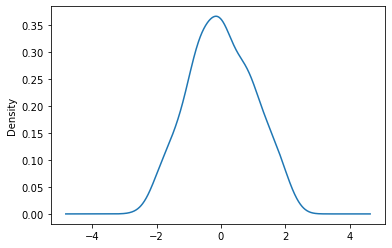

In [83]:
nfl_epa['season_n-1_epa'].plot.kde()

# Compose Complete DataFrame


In [84]:
wins3

,season_n,team_name,season_n-1_opposing_win_total,season_n-1_opposing_loss_total,season_n-1_opposing_tie_total,season_n-1_games_played,season_n-1_opposing_win_pct
0,2010,ARI,114,142,0,256,0.445312
1,2010,ATL,127,129,0,256,0.496094
2,2010,BAL,130,126,0,256,0.507812
3,2010,BUF,128,128,0,256,0.500000
4,2010,CAR,122,134,0,256,0.476562
...,...,...,...,...,...,...,...
411,2022,SEA,149,139,1,289,0.517301
412,2022,SF,154,135,0,289,0.532872
413,2022,TB,154,134,1,289,0.534602
414,2022,TEN,136,153,0,289,0.470588


In [85]:
wins2

,game_id,season,game_type,result,home_away,team_name,win,loss,tie,game_teams,opposing_team
0,2009_01_TEN_PIT,2009,REG,3.0,home_team,PIT,1,0,0,"[PIT, TEN]",TEN
1,2009_01_TEN_PIT,2009,REG,3.0,away_team,TEN,0,1,0,"[PIT, TEN]",PIT
2,2009_01_MIA_ATL,2009,REG,12.0,home_team,ATL,1,0,0,"[ATL, MIA]",MIA
3,2009_01_MIA_ATL,2009,REG,12.0,away_team,MIA,0,1,0,"[ATL, MIA]",ATL
4,2009_01_KC_BAL,2009,REG,14.0,home_team,BAL,1,0,0,"[BAL, KC]",KC
...,...,...,...,...,...,...,...,...,...,...,...
7227,2022_18_LA_SEA,2022,REG,NaN,away_team,LA,0,0,0,"[SEA, LA]",SEA
7228,2022_18_ARI_SF,2022,REG,NaN,home_team,SF,0,0,0,"[SF, ARI]",ARI
7229,2022_18_ARI_SF,2022,REG,NaN,away_team,ARI,0,0,0,"[SF, ARI]",SF
7230,2022_18_DAL_WAS,2022,REG,NaN,home_team,WAS,0,0,0,"[WAS, DAL]",DAL


In [86]:
nfl_epa

,team_name,season_n-1,season_n-1_epa,season_n
208,LA,2009,-2.462662,2010
130,DET,2009,-2.181131,2010
323,NYJ,2020,-2.098350,2021
194,JAX,2021,-2.085084,2022
210,LA,2011,-2.055532,2012
...,...,...,...,...
58,CAR,2015,2.065048,2016
355,SEA,2013,2.139636,2014
51,BUF,2021,2.164865,2022
280,NE,2016,2.251264,2017


In [87]:
nfl_market_exp_wins

,full_name,exp_wins,Over Odds,Under Odds,Week betsettled,ActualWins,Result,season_n,team_name
0,Arizona Cardinals,8.5,-110.0,-120.0,Week 16,10.0,Over,2009,ARI
1,Atlanta Falcons,8.5,100.0,-135.0,Week 17,9.0,Over,2009,ATL
2,Baltimore Ravens,8.5,-150.0,120.0,Week 17,9.0,Over,2009,BAL
3,Buffalo Bills,7.5,-120.0,-110.0,Week 15,6.0,Under,2009,BUF
4,Carolina Panthers,8.5,110.0,-140.0,Week 14,8.0,Under,2009,CAR
...,...,...,...,...,...,...,...,...,...
443,San Francisco 49ers,9.5,-140.0,120.0,NaN,NaN,NaN,2022,SF
444,Seattle Seahawks,5.5,-130.0,110.0,NaN,NaN,NaN,2022,SEA
445,Tampa Bay Buccaneers,11.5,-110.0,-110.0,NaN,NaN,NaN,2022,TB
446,Tennessee Titans,9.5,100.0,-120.0,NaN,NaN,NaN,2022,TEN


In [88]:
# adjust for team's relocation: OAK -> LV
team_OAK = nfl_epa['team_name'] == 'LV'
season_2019 = nfl_epa['season_n-1'] < 2019
nfl_epa.loc[((team_OAK)&(season_2019)),'team_name'] = 'OAK'

# adjust for team's relocation: SD -> LAC
team_SD = nfl_epa['team_name'] == 'SD'
season_2016 = nfl_epa['season_n-1'] < 2016
nfl_epa.loc[((team_SD)&(season_2016)),'team_name'] = 'LAC'

# adjust for team's relocation: STL -> LA
team_STL = nfl_epa['team_name'] == 'LA'
season_2015 = nfl_epa['season_n-1'] < 2015
nfl_epa.loc[((team_STL)&(season_2015)),'team_name'] = 'STL'

# merge previous seasons's epa to the team of the current season
wins3_epa = pd.merge(wins3, nfl_epa, on=['team_name', 'season_n'])
wins3_epa

,season_n,team_name,season_n-1_opposing_win_total,season_n-1_opposing_loss_total,season_n-1_opposing_tie_total,season_n-1_games_played,season_n-1_opposing_win_pct,season_n-1,season_n-1_epa
0,2010,ARI,114,142,0,256,0.445312,2009,0.232340
1,2010,ATL,127,129,0,256,0.496094,2009,0.320527
2,2010,BAL,130,126,0,256,0.507812,2009,1.245432
3,2010,BUF,128,128,0,256,0.500000,2009,-0.587669
4,2010,CAR,122,134,0,256,0.476562,2009,0.069489
...,...,...,...,...,...,...,...,...,...
404,2022,SEA,149,139,1,289,0.517301,2021,0.231417
405,2022,SF,154,135,0,289,0.532872,2021,0.709444
406,2022,TB,154,134,1,289,0.534602,2021,1.710975
407,2022,TEN,136,153,0,289,0.470588,2021,0.503382


In [89]:
# merge current season's exp wins to the opposing team of the current season
# aggregate exp wins similar to season_n-1 win totals
nfl_market_exp_wins.rename(columns={'team_name':'opposing_team'}, inplace=True)
wins2.rename(columns={'season':'season_n'}, inplace=True)
wins2_market_exp_wins = pd.merge(wins2, nfl_market_exp_wins, on=['season_n', 'opposing_team'])
wins2_market_exp_wins

,game_id,season_n,game_type,result,home_away,team_name,win,loss,tie,game_teams,opposing_team,full_name,exp_wins,Over Odds,Under Odds,Week betsettled,ActualWins,Result
0,2009_01_TEN_PIT,2009,REG,3.0,home_team,PIT,1,0,0,"[PIT, TEN]",TEN,Tennessee Titans,9.0,-105.0,-125.0,Week 16,8.0,Under
1,2009_02_HOU_TEN,2009,REG,-3.0,away_team,HOU,1,0,0,"[TEN, HOU]",TEN,Tennessee Titans,9.0,-105.0,-125.0,Week 16,8.0,Under
2,2009_03_TEN_NYJ,2009,REG,7.0,home_team,NYJ,1,0,0,"[NYJ, TEN]",TEN,Tennessee Titans,9.0,-105.0,-125.0,Week 16,8.0,Under
3,2009_04_TEN_JAX,2009,REG,20.0,home_team,JAX,1,0,0,"[JAX, TEN]",TEN,Tennessee Titans,9.0,-105.0,-125.0,Week 16,8.0,Under
4,2009_05_IND_TEN,2009,REG,-22.0,away_team,IND,1,0,0,"[TEN, IND]",TEN,Tennessee Titans,9.0,-105.0,-125.0,Week 16,8.0,Under
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7227,2022_14_CAR_SEA,2022,REG,NaN,away_team,CAR,0,0,0,"[SEA, CAR]",SEA,Seattle Seahawks,5.5,-130.0,110.0,NaN,NaN,NaN
7228,2022_15_SF_SEA,2022,REG,NaN,away_team,SF,0,0,0,"[SEA, SF]",SEA,Seattle Seahawks,5.5,-130.0,110.0,NaN,NaN,NaN
7229,2022_16_SEA_KC,2022,REG,NaN,home_team,KC,0,0,0,"[KC, SEA]",SEA,Seattle Seahawks,5.5,-130.0,110.0,NaN,NaN,NaN
7230,2022_17_NYJ_SEA,2022,REG,NaN,away_team,NYJ,0,0,0,"[SEA, NYJ]",SEA,Seattle Seahawks,5.5,-130.0,110.0,NaN,NaN,NaN


In [90]:
wins4 = wins2_market_exp_wins.groupby(['season_n','team_name']).agg({'exp_wins':'sum', 'game_teams':'count'}).reset_index()

In [91]:
wins4

,season_n,team_name,exp_wins,game_teams
0,2009,ARI,125.5,16
1,2009,ATL,133.5,16
2,2009,BAL,130.5,16
3,2009,BUF,132.0,16
4,2009,CAR,136.0,16
...,...,...,...,...
443,2022,SEA,148.5,17
444,2022,SF,143.5,17
445,2022,TB,130.0,17
446,2022,TEN,146.5,17


In [92]:
wins4.rename(columns= {'exp_wins':'season_n_opposing_exp_wins', 'game_teams':'season_n_games'},inplace=True)
wins4['season_n_opposing_exp_win_pct'] = wins4['season_n_opposing_exp_wins'] / (wins4['season_n_games'] * wins4['season_n_games'])

In [93]:
wins4

,season_n,team_name,season_n_opposing_exp_wins,season_n_games,season_n_opposing_exp_win_pct
0,2009,ARI,125.5,16,0.490234
1,2009,ATL,133.5,16,0.521484
2,2009,BAL,130.5,16,0.509766
3,2009,BUF,132.0,16,0.515625
4,2009,CAR,136.0,16,0.531250
...,...,...,...,...,...
443,2022,SEA,148.5,17,0.513841
444,2022,SF,143.5,17,0.496540
445,2022,TB,130.0,17,0.449827
446,2022,TEN,146.5,17,0.506920


In [94]:
combined_df = pd.merge(wins3_epa, wins4, on=['team_name', 'season_n'])

In [95]:
season_n_wins = nfl_market_exp_wins[['ActualWins','season_n','opposing_team']].rename(columns={'ActualWins':'season_n_wins','opposing_team':'team_name'})
nfl_season_df = pd.merge(combined_df,season_n_wins, on=['team_name', 'season_n'])

In [96]:
cols = ['season_n', 'team_name','season_n-1_epa', 'season_n-1_opposing_win_pct','season_n_opposing_exp_win_pct','season_n_wins']
nfl_season_df[cols]

,season_n,team_name,season_n-1_epa,season_n-1_opposing_win_pct,season_n_opposing_exp_win_pct,season_n_wins
0,2010,ARI,0.232340,0.445312,0.482422,5.0
1,2010,ATL,0.320527,0.496094,0.488281,13.0
2,2010,BAL,1.245432,0.507812,0.488281,12.0
3,2010,BUF,-0.587669,0.500000,0.517578,4.0
4,2010,CAR,0.069489,0.476562,0.503906,2.0
...,...,...,...,...,...,...
404,2022,SEA,0.231417,0.517301,0.513841,NaN
405,2022,SF,0.709444,0.532872,0.496540,NaN
406,2022,TB,1.710975,0.534602,0.449827,NaN
407,2022,TEN,0.503382,0.470588,0.506920,NaN


In [97]:
import os
nfl_season_df[cols].to_csv(os.path.join(os.getcwd(),'nfl_season_data.csv'))

,season_n,team_name,season_n-1_epa,season_n-1_opposing_win_pct,season_n_opposing_exp_win_pct,season_n_wins
0,2010,ARI,0.232340,0.445312,0.482422,5.0
1,2010,ATL,0.320527,0.496094,0.488281,13.0
2,2010,BAL,1.245432,0.507812,0.488281,12.0
3,2010,BUF,-0.587669,0.500000,0.517578,4.0
4,2010,CAR,0.069489,0.476562,0.503906,2.0
...,...,...,...,...,...,...
404,2022,SEA,0.231417,0.517301,0.513841,NaN
405,2022,SF,0.709444,0.532872,0.496540,NaN
406,2022,TB,1.710975,0.534602,0.449827,NaN
407,2022,TEN,0.503382,0.470588,0.506920,NaN
